In [90]:
%matplotlib inline

# useful packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
import time
import pandas as pd
from scipy.optimize import minimize

from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram
from qiskit.quantum_info import Statevector
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_state_qsphere
import qiskit

In [91]:
# graph generation

def draw_graph(G, colors, pos):
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
        edge_labels = nx.get_edge_attributes(G, "weight")
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

def graph_generation(dim):
    # Generating the system
    N = dim
    G1 = nx.grid_2d_graph(N,N)
    pos = dict( (n, n) for n in G1.nodes() )
    labels = dict( ((i, j), i * N + j) for i, j in G1.nodes() )
    # Transform to weighted graph:
    n = N**2
    V = np.arange(0, N, 1)

    E =[]

    tuples = []
    other_tup = []
    point_edge_map = []
    other_map = []
    relations = []

    for edge in G1.edges:
        point1 = edge[0]
        strpoint1 = str(point1[0]) + str(point1[1])
        point2 = edge[1]
        strpoint2 = str(point2[0]) + str(point2[1])
        if not strpoint1 in point_edge_map:
            point_edge_map.append(strpoint1)
            tuples.append(edge[0])
        if not strpoint2 in other_map:
            other_map.append(strpoint2)
            other_tup.append(edge[1])
        relations.append((strpoint1, strpoint2))

    tuples.append(other_tup[len(other_tup) - 1])
    point_edge_map.append(other_map[len(other_map) - 1])

    dic = {}
    for i in range(len(point_edge_map)):
        dic[i] = point_edge_map[i]

    point_edge_map = np.array(point_edge_map)
    relations = np.array(relations)

    for relation in relations:
        ver1 = relation[0]
        ver2 = relation[1]
        point1 = np.where(point_edge_map == ver1)[0][0]
        point2 = np.where(point_edge_map == ver2)[0][0]
        edge = (point1, point2, 1.0)
        E.append(edge)

    G = nx.Graph()

    G.add_nodes_from(V)

    G.add_weighted_edges_from(E)

    colors = ["b" for node in G.nodes()]
    pos = dict()
    for i in range(n):
        pos[i] = tuples[i]


    draw_graph(G, colors, pos)
    
    # Matrix Representation of Graph
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = temp["weight"]
                
    return G, w, pos

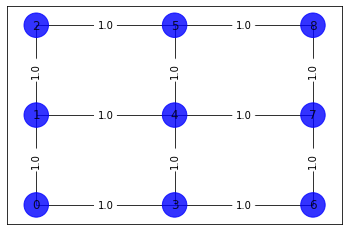

In [92]:
dim = 3
G, w, pos = graph_generation(dim)

/var/folders/4_/lqqy0k816zv9vb8d2ss9lqpc0000gn/T/ipykernel_42128/462324063.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


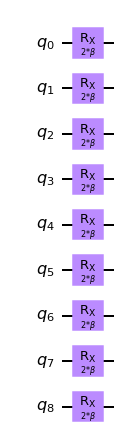

In [93]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter

# Adjacency is essentially a matrix which tells you which nodes are
# connected. This matrix is given as a sparse matrix, so we need to
# convert it to a dense matrix
adjacency = nx.adjacency_matrix(G).todense()

nqubits = dim**2

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw('mpl')

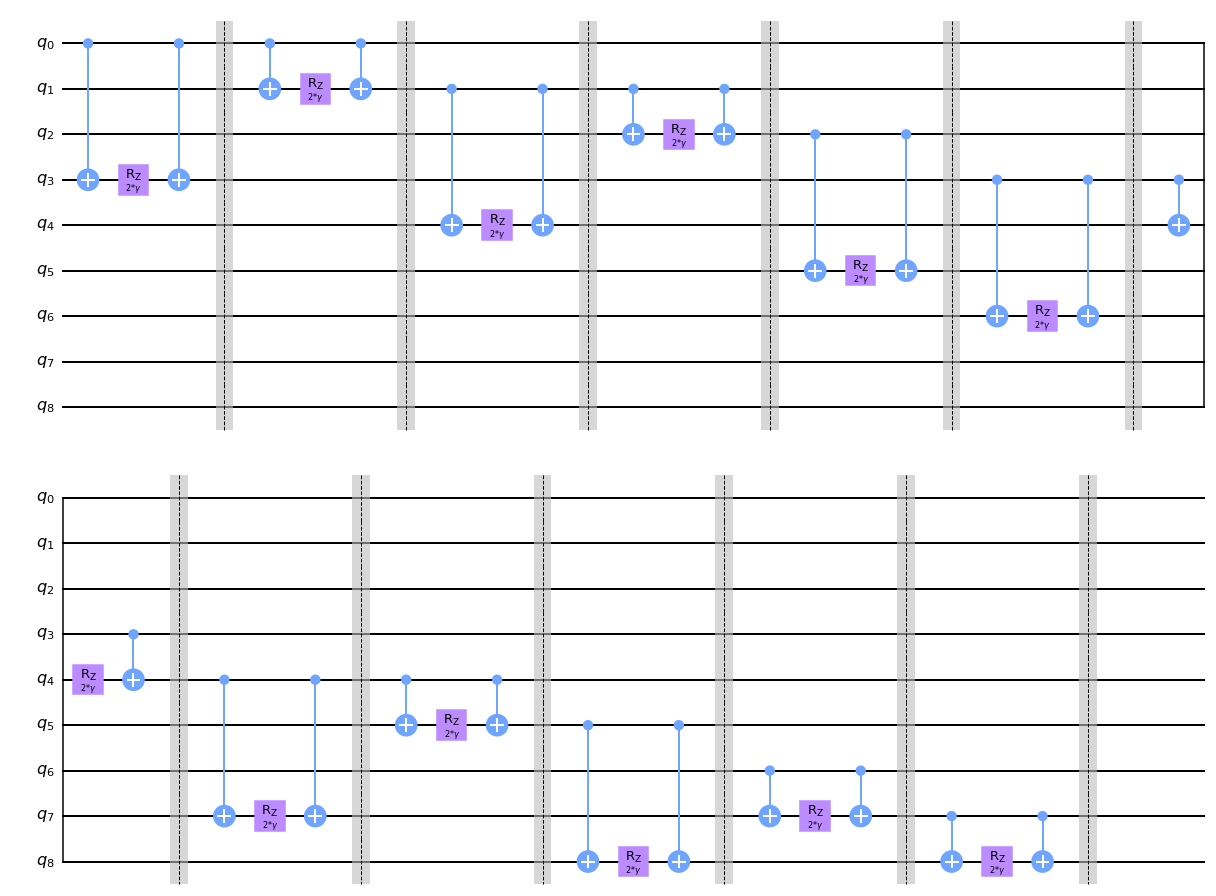

In [94]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(nqubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw('mpl')

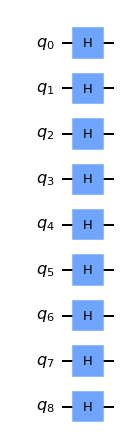

In [95]:
qc_0 = QuantumCircuit(nqubits)
for i in range(0, nqubits):
    qc_0.h(i)
    
qc_0.draw('mpl')

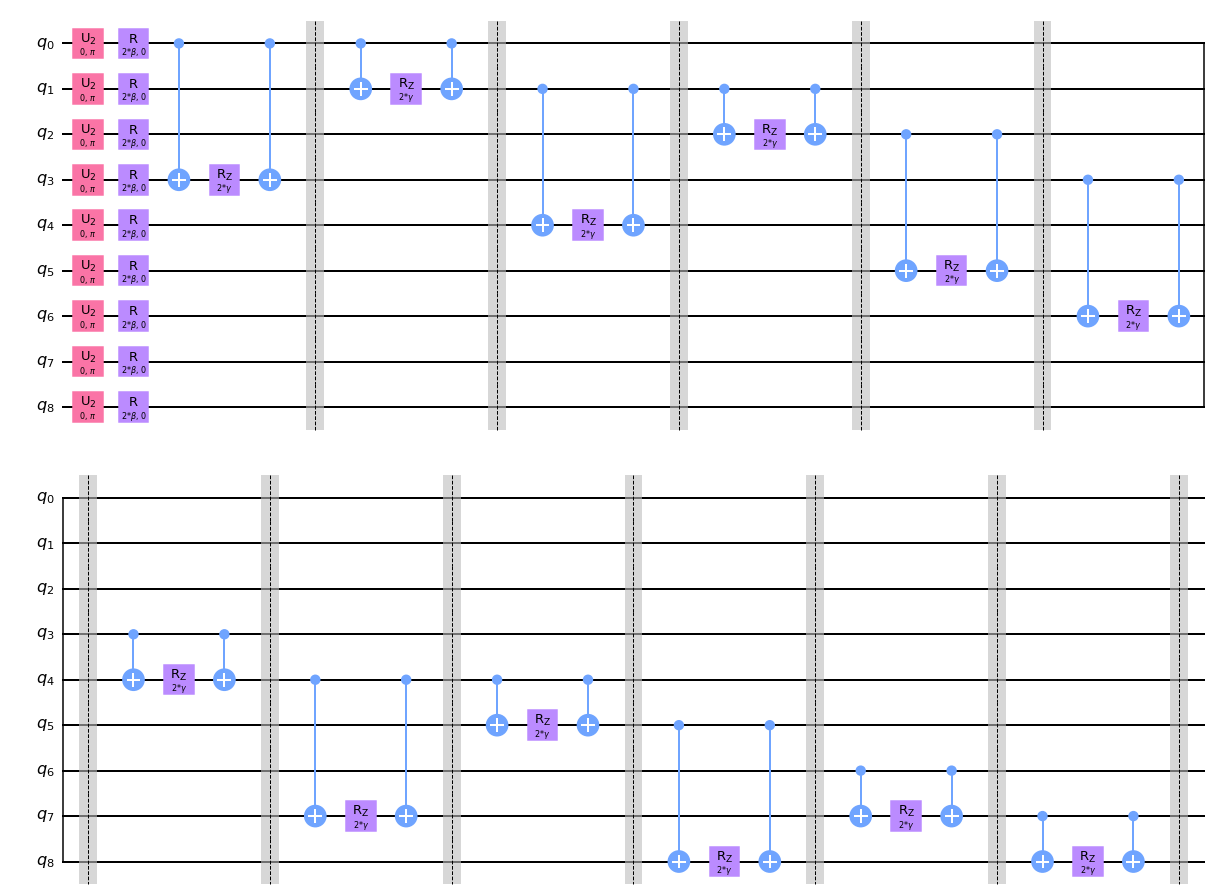

In [96]:
# Total circuit
qc_qaoa = QuantumCircuit(nqubits)

qc_qaoa.append(qc_0, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, nqubits)])
qc_qaoa.append(qc_p, [i for i in range(0, nqubits)])

qc_qaoa.decompose().decompose().draw('mpl')

In [97]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj


def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(G, seed, shots=1024):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator = seed, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [98]:
res

     fun: -8.568359375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([2.75402154, 0.33384264])

In [99]:
%%time
backend = Aer.get_backend('aer_simulator')
backend.shots = 1024
seeds = np.linspace(201, 10000, 9800, dtype = 'int64')

writer = pd.ExcelWriter('3x3 data.xlsx', engine = 'xlsxwriter')

data = pd.DataFrame()
size = np.full_like(seeds, 9)
optimizER = 'COBYLA'
opt = [optimizER]*len(seeds)
#first_state = []
#first_prob = []
#first_energy = []
#terminate_it = []
#energy = []
exe_time = []
#max_cum_objective = []
solution = []
solution_prob = []
#solution_objective = []

for seed in seeds:
    #begin recording time
    tic = time.time()

    expectation = get_expectation(G, seed = 10)

    res = minimize(expectation, 
                          [1.0, 1.0], 
                          method = optimizER)

    qc_res = create_qaoa_circ(G, res.x)

    result = backend.run(qc_res, seed_simulator=seed).result()

    counts = result.get_counts()

    # stop recording time
    toc = time.time()

    time_taken = toc - tic

    counts = dict(counts)
    prob, state = max(counts.values()), max(counts, key = counts.get)
    
    # data collection
    #first_state.append(f_state)
    #first_prob.append(f_prob)
    #first_energy.append(values[0])
    #terminate_it.append(len(Parameters))
    #energy.append(result.eigenvalue.real)
    exe_time.append(time_taken)
    #max_cum_objective.append(result.eigenvalue.real + offset)
    solution_prob.append(prob)
    solution.append(state)
    #solution_objective.append(qp.objective.evaluate(x))

# data base
data['seed'] = seeds
data['size'] = size
data['optimizer'] = opt
# data['state after 1st iteration'] = first_state
# data['probability for the 1st state'] = first_prob
# data['energy for the 1st state'] = first_energy
# data['terminate iterations'] = terminate_it
# data['energy'] = energy
data['time (s)'] = exe_time
# data['max cut objective'] = max_cum_objective
data['solution'] = solution
data['solution probability'] = solution_prob
# data['solution objective'] = solution_objective
data.to_excel(writer, sheet_name = 'different backend.run seeds')
writer.save()
print('finish')

finish
CPU times: user 49min 38s, sys: 30.2 s, total: 50min 8s
Wall time: 3h 9min 53s


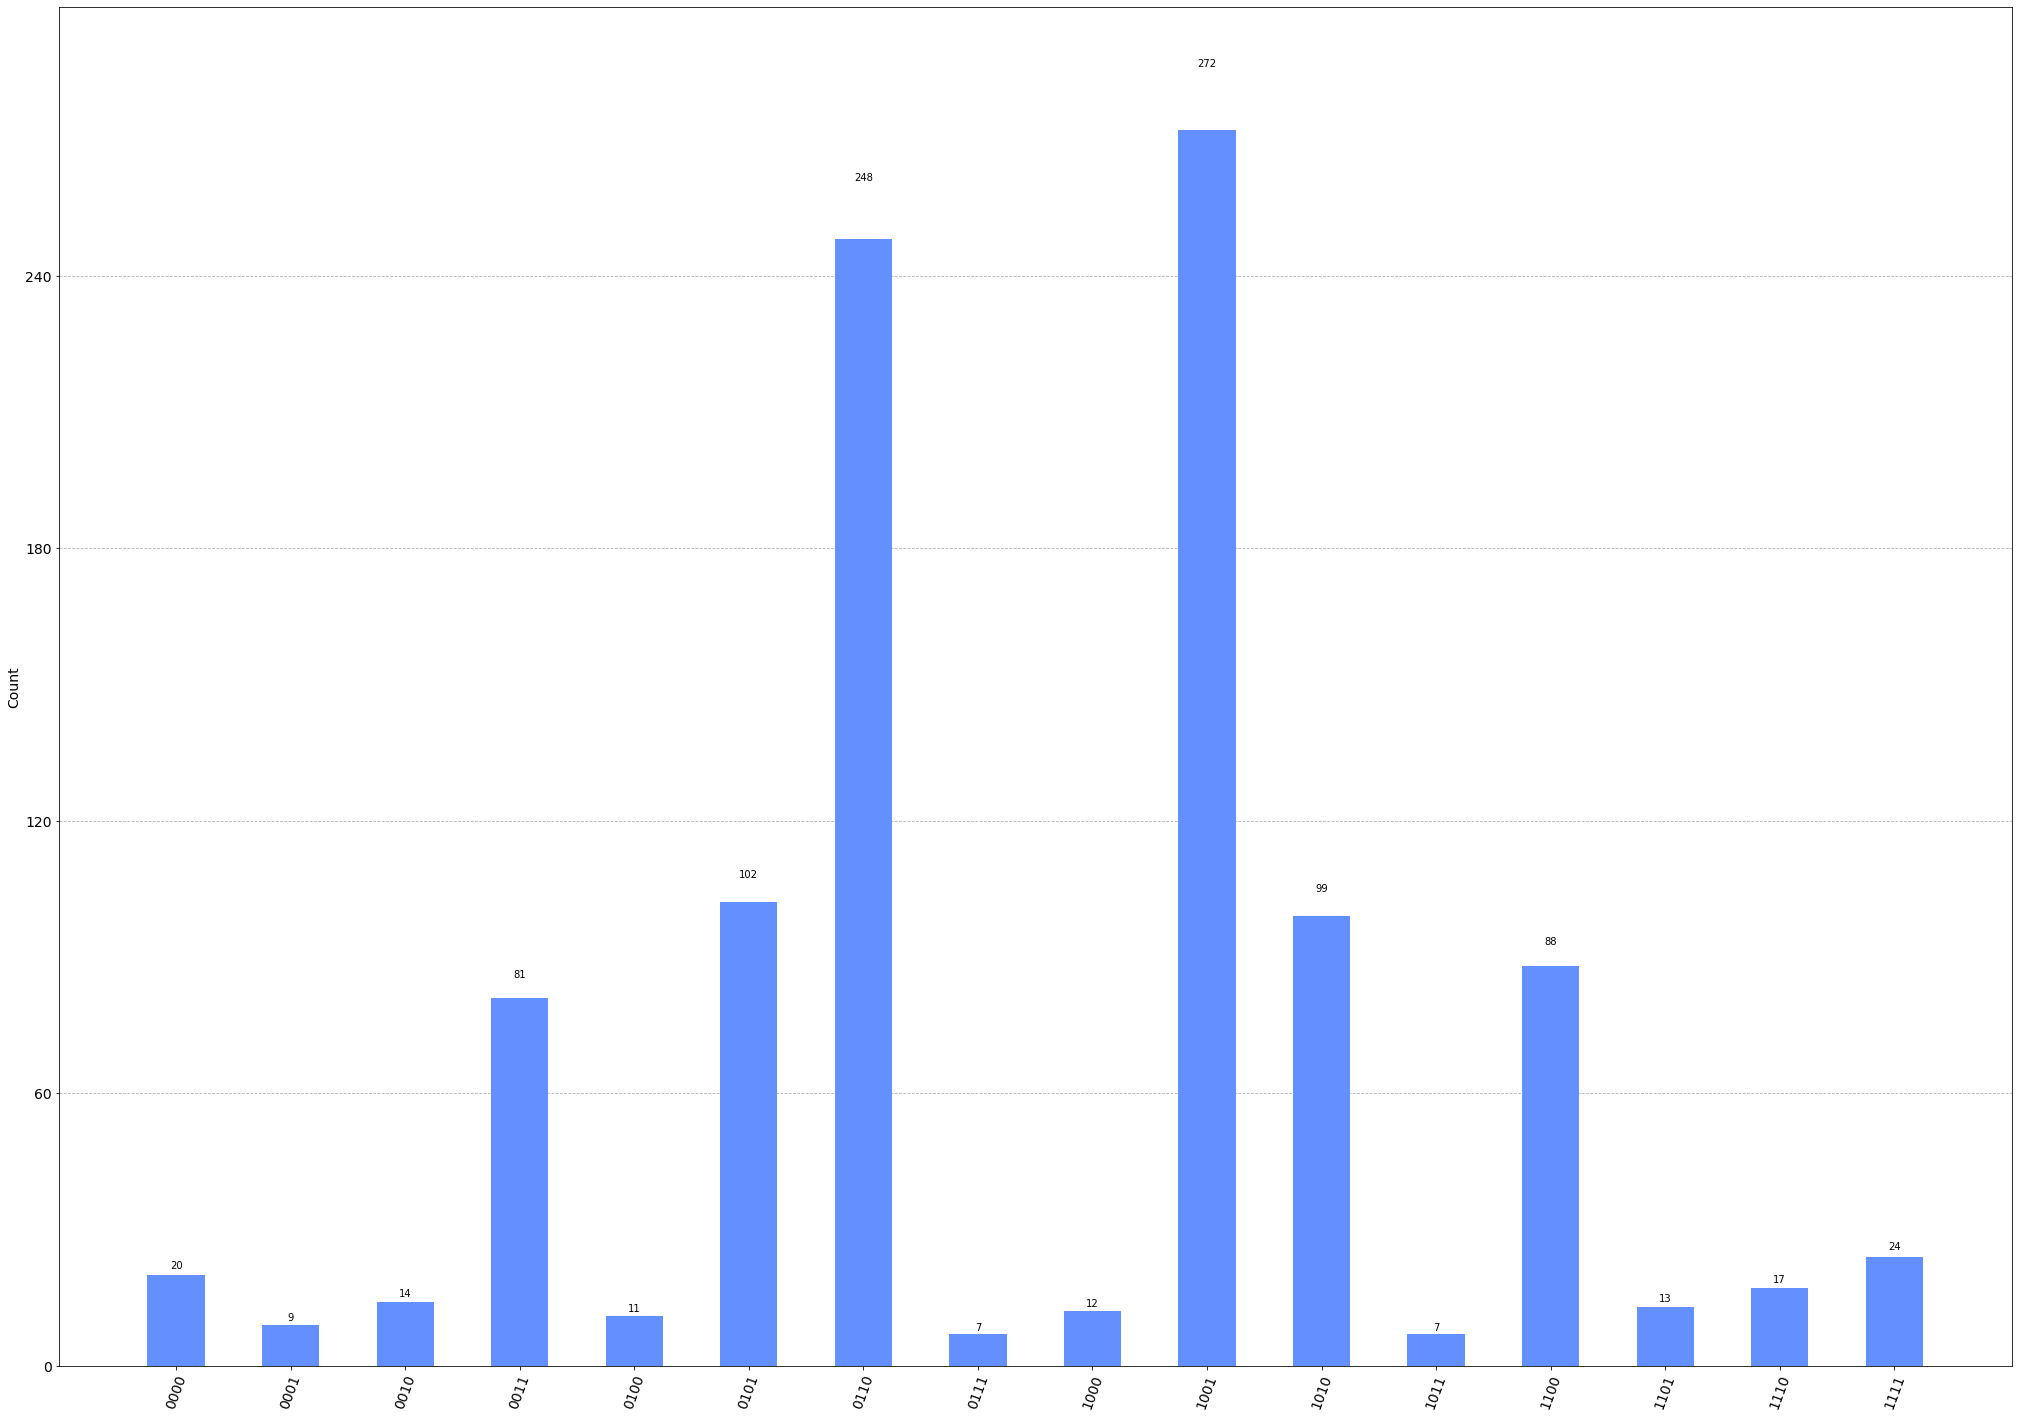

In [27]:
from qiskit.visualization import plot_histogram

plot_histogram(counts, figsize=(35, 25))